# 自己回帰和分移動平均モデル（ARIMAモデル）

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## 訓練データ生成

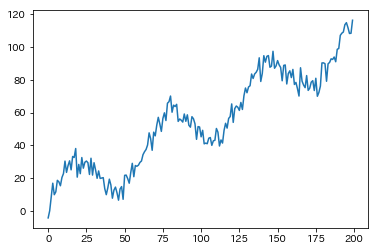

In [2]:
xx = np.arange(200)
xx = 15 * np.sin(0.1 * xx) + 4 * np.random.normal(size=200) + 5. + 0.5 * xx
plt.plot(xx)

## 学習

時系列データが$X=[x_{1}, x_{2}, .., x_{n}]$のとき、ARIMAモデルは、$\Delta^{d} x_{s} = w_{0}+ \sum_{j=1}^{m} w_{j} \Delta^{d} x_{s-j} + \sum_{j=1}^{m'} \theta_{j} \epsilon_{s-j} + \epsilon_{s}$で与えられる。

ただし、$w_{j}, \theta_{j}$は重みパラメータ、$\epsilon_{s}$は時刻$s$でのノイズであり平均$0$、分散$\sigma^{2}$の正規分布に従うものと仮定する。また$\Delta^{d}$は$d$階差分を表し、$L$を後退オペレータ($L^{j} x_{i} = x_{i-j}$)とすると$\Delta^{d} = (1-L)^{d}$と定義される。

差分を取り、ARMAモデルと同じ手順で学習を行う。

In [3]:
x_train = xx
n = len(x_train)
m_ar = 13
m_ma = 2
d = 1 # d >= 1

# d階差分
x = np.concatenate([np.zeros(d), x_train])
for _ in range(d):
    x = x - np.roll(x, 1)
x = np.concatenate([np.zeros(m_ar), x[d:]])

In [4]:
# wの初期値をARモデルによって求める
X = np.array([x[m_ar-i: m_ar-i+n] for i in range(1, m_ar+1)])
x_sum = np.sum(X, axis=1)
A = np.dot(X, X.T)
b = np.dot(X, x[m_ar:])

w0 = 0
max_iter = 100
for _ in range(max_iter):
    prev_w0 = w0
    w = np.linalg.solve(A, b - x_sum*w0)
    w0 = np.mean(x[m_ar:] - np.dot(X.T, w))
    if np.allclose(prev_w0, w0):
        break

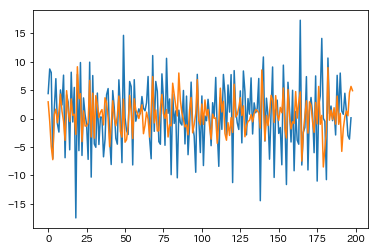

In [5]:
# 差分に対するARモデルの結果
y_test = w0 + np.dot(X.T, w)
plt.plot(x[m_ar+1:-1])
plt.plot(y_test[1:])

In [6]:
e_tilde = np.zeros(n+2*m_ma)
e_hat = np.zeros(n+m_ma)

def backcast(theta):
    for i in reversed(range(n)):
        e_tilde[m_ma+i] = x[m_ar+i] - w0 - np.dot(w, x[i: i+m_ar][::-1]) - np.dot(theta, e_tilde[m_ma+i+1: i+2*m_ma+1])

def forward(theta):
    eps = np.array([e_tilde[i:i+m_ma][::-1] for i in range(n)])
    e_hat[m_ma:] = x[m_ar:] - w0 - np.dot(X.T, w) - np.dot(eps, theta)
    e_hat[m_ma:] = e_hat[m_ma:]

In [7]:
max_iter = 10000
eta1 = 0.001
eta2 = 0.01
regularization_rate = 0.01

theta = np.random.randn(m_ma) * 0.1
for _ in range(max_iter):
    backcast(theta)
    forward(theta)
    
    # sigma2の更新 
    var = np.var(e_hat[m_ma:])
    # wの更新
    delta_w = np.dot(X, e_hat[m_ma:])
    w += eta1 * delta_w / var
    # thetaの更新
    eps = np.array([e_hat[m_ma-i:m_ma-i+n] for i in range(1, m_ma+1)])
    delta_theta = np.dot(eps, e_hat[m_ma:])
    theta +=  eta2 * delta_theta / var - regularization_rate * theta
    # w0の更新
    w0 = np.mean(x[m_ar:] - np.dot(X.T, w) - np.dot(eps.T, theta))

    if np.allclose(np.sum(delta_w**2) + np.sum(delta_theta**2), 0):
        break

std = np.sqrt(var)

## 結果

$\Delta^{d} x_{s} = w_{0}+ \sum_{j=1}^{m} w_{j} \Delta^{d} x_{s-j} + \sum_{j=1}^{m'} \theta_{j} \epsilon_{s-j}$で差分に対するARMAモデルの結果を求める。

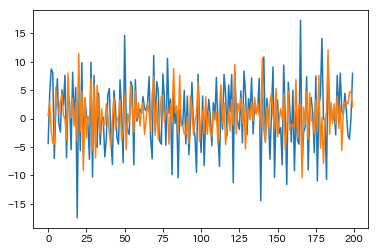

In [8]:
eps = np.array([e_hat[m_ma-i:m_ma-i+n] for i in range(1, m_ma+1)])
y_test = w0 + np.dot(X.T, w) + np.dot(eps.T, theta)

plt.plot(x[m_ar:])
plt.plot(y_test)

さらに、d階差分の逆の操作をすることで、もとのXに対するARIMAモデルの結果を求める。

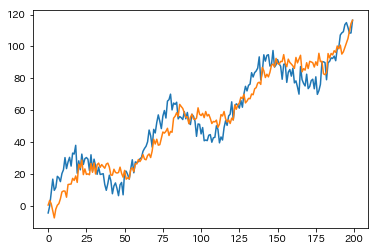

In [9]:
for _ in range(d):
    y_test = np.cumsum(y_test)

plt.plot(x_train, label='training data')
plt.plot(y_test, label='ARIMA model')